# Demo 1 – Baseline approaches

This demo is about an investigation of MR data, its preparation, and baseline approaches. We will start by familiarizing ourselves with the fastMRI challenge - the biggest competition in the field of scan acceleration. The challenge provides the fastMRI dataset - the most complete dataset with **raw** MR data from several major vendors of the medical imaging industry. 

This demo will use raw data of single-coil coronal proton density-weighted knee scans from the [fastMRI dataset](https://fastmri.med.nyu.edu/). Note that single-coil scans are generated from multi-coil data using coil combination.   
The fastMRI dataset **may not be redistributed in any way**. To repeat experiments, download your copy of the dataset:
1. File the form on the [fastMRI website](https://fastmri.med.nyu.edu/)
2. Recieve an email from organizers of the fastMRI challenge with download links
3. Download chunks of the dataset that you are interested in. In this demo we use a single file (file1000000.h5) from the 'knee_singlecoil_val' subset

Let us define all required imports here:

In [38]:
import h5py
import os 
import torch
import requests

import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Sequence, Tuple, Union
from tqdm import tqdm
from pathlib import Path
from piq import ssim

from models import Unet
from data_transforms import UnetDataTransform

## Part 1. Investigation of data

Before we start experimenting reconstruction and machine learning techniques, let us have a look at the data.

In [2]:
file_name = 'data/file1000000.h5'
with h5py.File(file_name, "r") as hf:
    kspace = torch.from_numpy(hf["kspace"][()])
    
    # We will need that later
    attrs = dict(hf.attrs)
    target = hf['reconstruction_esc'][()]
    
    
print(f'K-space shape (slice num, height, width): {kspace.shape}')
print(f'Note that the data is complex-valued:', kspace.dtype)

K-space shape (slice num, height, width): torch.Size([35, 640, 368])
Note that the data is complex-valued: torch.complex64


Below we define several utilitary functions, which we will use later.

In [44]:
def to_two_channel_complex(data: torch.Tensor) -> torch.Tensor:
    """ Change data representation from one channel complex-valued to two channers real valued """
    real = data.real
    imag = data.imag
    result = torch.empty((*data.shape, 2), dtype=torch.float32)
    result[..., 0] = real
    result[..., 1] = imag
    return result


def complex_abs(data: torch.Tensor, keepdim: bool = False) -> torch.Tensor:
    """ Convert complex image to a magnitude image (projection from complex to a real plane) """
    assert data.size(-1) == 2
    return (data ** 2).sum(dim=-1, keepdim=keepdim).sqrt()


def single_coil_kspace_to_image(kspace: torch.Tensor) -> torch.Tensor:
    """ Convert k-space to the corresponding image using Fourier transforms """
    kspace_shifted = torch.fft.ifftshift(kspace)
    image_shifted = torch.fft.ifft2(kspace_shifted)
    image = torch.fft.fftshift(image_shifted).real
    return image

def normalize_tensor(tensor: torch.Tensor) -> torch.Tensor:
    """ Map tensor values to [0, 1] """
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    tensor = tensor.clamp(0, 1)
    return tensor

First, let us examine how k-space looks. Note that this is single-coil k-space data, which means that these k-spaces fully correspond to the resulting images.   
Our data is stored in the form of scans. It means that each scan file corresponds to the whole volume of acquired data. We can select several slices from the volume for convenient exploration. Feel free to change slice numbers to see different parts of the k-space.

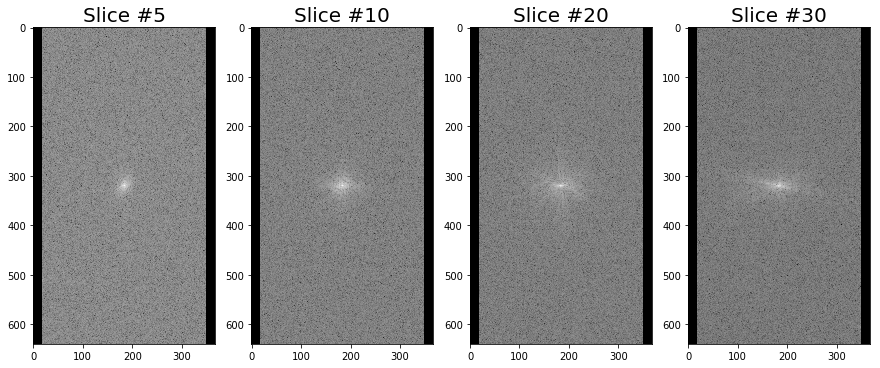

In [4]:
slice_nums = [5, 10, 20, 30]

plt.figure(figsize=(15, 7))
for i, slice_num in enumerate(slice_nums):
    
    # Select a slice from the volume of k-spaces
    slice_kspace = kspace[slice_num]
    
    # Recall that our k-space data is complex-valued. 
    # It means that we can either visualize real and imag parts independently or project complex tensor on a real plane.
    # Let's do the latter.
    magnitude_slice_kspace = complex_abs(to_two_channel_complex(slice_kspace))
    
    # It is more convenient to observe k-space data after logarithmic scaling
    magnitude_slice_kspace_to_show = torch.log(magnitude_slice_kspace + 1e-8)

    plt.subplot(1, len(slice_nums), i + 1)
    plt.imshow(magnitude_slice_kspace_to_show, cmap='gray')
    plt.title(f'Slice #{slice_num}', fontsize=20)
    
plt.show()

Now let us see how corresponding images look.

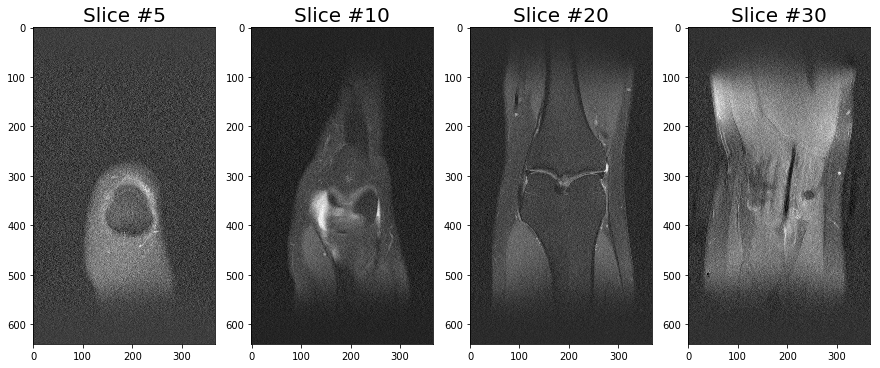

In [5]:
plt.figure(figsize=(15, 7))
for i, slice_num in enumerate(slice_nums):
    
    # Select a slice from the volume of k-spaces
    slice_kspace = kspace[slice_num]
    
    # Convert k-space to the corresponding image
    magnitude_slice_image = single_coil_kspace_to_image(slice_kspace)

    plt.subplot(1, len(slice_nums), i + 1)
    plt.imshow(magnitude_slice_image, cmap='gray')
    plt.title(f'Slice #{slice_num}', fontsize=20)
    
plt.show()

Now we can see plain knee images that correspond to the fully sampled data. Let's now have a look at what happens when we acquire only a part of the k-space to speed up the examination process.

## Part 2. Undersampling

The code for mask generation was taken from the [official repository of the fastMRI challenge](https://github.com/facebookresearch/fastMRI). 

In [6]:
class MaskFunc:
    """
    An object for GRAPPA-style sampling masks.
    This crates a sampling mask that densely samples the center while
    subsampling outer k-space regions based on the undersampling factor.
    """

    def __init__(self, center_fractions: Sequence[float], accelerations: Sequence[int]):
        """
        Args:
            center_fractions: Fraction of low-frequency columns to be retained.
                If multiple values are provided, then one of these numbers is
                chosen uniformly each time.
            accelerations: Amount of under-sampling. This should have the same
                length as center_fractions. If multiple values are provided,
                then one of these is chosen uniformly each time.
        """
        if not len(center_fractions) == len(accelerations):
            raise ValueError(
                "Number of center fractions should match number of accelerations"
            )

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.rng = np.random.RandomState()  # pylint: disable=no-member

    def __call__(
        self, shape: Sequence[int], seed: Optional[Union[int, Tuple[int, ...]]] = None
    ) -> torch.Tensor:
        raise NotImplementedError

    def choose_acceleration(self):
        """Choose acceleration based on class parameters."""
        choice = self.rng.randint(0, len(self.accelerations))
        center_fraction = self.center_fractions[choice]
        acceleration = self.accelerations[choice]

        return center_fraction, acceleration


class RandomMaskFunc(MaskFunc):
    """
    RandomMaskFunc creates a sub-sampling mask of a given shape.
    The mask selects a subset of columns from the input k-space data. If the
    k-space data has N columns, the mask picks out:
        1. N_low_freqs = (N * center_fraction) columns in the center
           corresponding to low-frequencies.
        2. The other columns are selected uniformly at random with a
        probability equal to: prob = (N / acceleration - N_low_freqs) /
        (N - N_low_freqs). This ensures that the expected number of columns
        selected is equal to (N / acceleration).
    It is possible to use multiple center_fractions and accelerations, in which
    case one possible (center_fraction, acceleration) is chosen uniformly at
    random each time the RandomMaskFunc object is called.
    For example, if accelerations = [4, 8] and center_fractions = [0.08, 0.04],
    then there is a 50% probability that 4-fold acceleration with 8% center
    fraction is selected and a 50% probability that 8-fold acceleration with 4%
    center fraction is selected.
    """

    def __call__(
        self, shape: Sequence[int], seed: Optional[Union[int, Tuple[int, ...]]] = None
    ) -> torch.Tensor:
        """
        Create the mask.
        Args:
            shape: The shape of the mask to be created. The shape should have
                at least 3 dimensions. Samples are drawn along the second last
                dimension.
            seed: Seed for the random number generator. Setting the seed
                ensures the same mask is generated each time for the same
                shape. The random state is reset afterwards.
        Returns:
            A mask of the specified shape.
        """
        if len(shape) < 3:
            raise ValueError("Shape should have 3 or more dimensions")


        num_cols = shape[-2]
        center_fraction, acceleration = self.choose_acceleration()

        # create the mask
        num_low_freqs = int(round(num_cols * center_fraction))
        prob = (num_cols / acceleration - num_low_freqs) / (
            num_cols - num_low_freqs
        )
        mask = self.rng.uniform(size=num_cols) < prob
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad : pad + num_low_freqs] = True

        # reshape the mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))
        return mask

Roughly speaking, k-space contains low and high-frequency information. Low-frequency information is mainly stored in the central part of a k-space and corresponds to overall structural information. High frequencies and primarily stored in the outer pars of a k-space and correspond to small details, borders, corners, etc.   

Organizers of the fastMRI challenge provided us with several implemented undersampling masks. In this demo, we will consider a random mask, which samples some predefined fraction (`center_fractions` in the code) of the central part of a k-space and then randomly samples lines from other parts of the k-space. The number of additional lines to be sampled depends on the acceleration rate of choice.

In the following example, we will experiment with two acceleration rates (R): x4 and x8. R=4 means that 25% of k-space lines are sampled, and R=8 corresponds to only 12.5%. It means that we will always sample `center_fractions` lines from the center and R - `center_fractions` randomly from other regions.

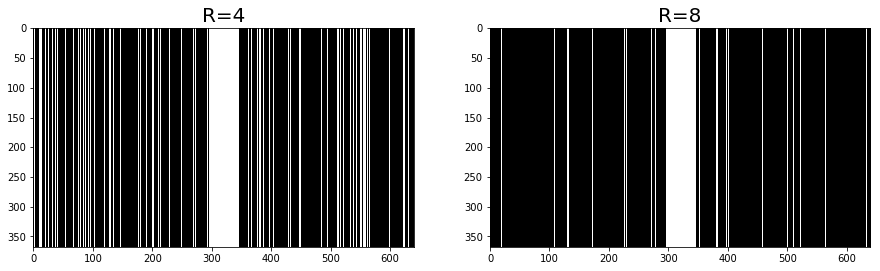

In [7]:
center_fractions = [0.08]
accelerations = [4, 8]
masks = {}

plt.figure(figsize=(15, 7))
for i, acc in enumerate(accelerations):
    mask_generator = RandomMaskFunc(center_fractions, [acc])
    mask = mask_generator(kspace.shape)
    masks[acc] = mask
    
    # Our generated mask is 1D. Let us make it 2D for easier visualization
    ones = torch.ones(kspace.shape)
    mask_2d = ones * mask
    
    plt.subplot(1, len(accelerations), i + 1)
    plt.imshow(mask_2d[0].T, cmap='gray')
    plt.title(f'R={acc}', fontsize=20)
    
plt.show()

Now, when we generated our masks, let's mask our k-space with them to simulate accelerated data:

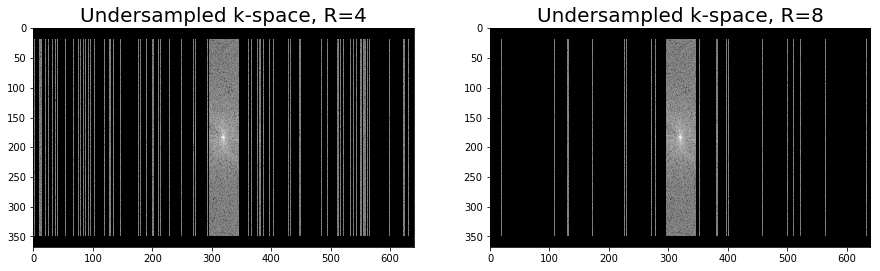

In [8]:
slice_num = 20
slice_kspace = kspace[slice_num]
undersampled_kspaces = {}

plt.figure(figsize=(15, 7))
for i, (acc, mask) in enumerate(masks.items()):
    
    # Element-wise multiplication with 1D masks to zero-out k-space lines
    undersampled_kspace = slice_kspace * mask
    undersampled_kspaces[acc] = undersampled_kspace

    # Convert to magnitude as above
    magnitude_slice_kspace = complex_abs(to_two_channel_complex(undersampled_kspace))
    
    # It is more convenient to observe k-space data after logarithmic scaling
    magnitude_slice_kspace_to_show = torch.log(magnitude_slice_kspace + 1e-8)
    
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(magnitude_slice_kspace_to_show[0].T, cmap='gray')
    plt.title(f'Undersampled k-space, R={acc}', fontsize=20)
    
plt.show()

Now we can finally see our zero-filled images that need to be enhanced.

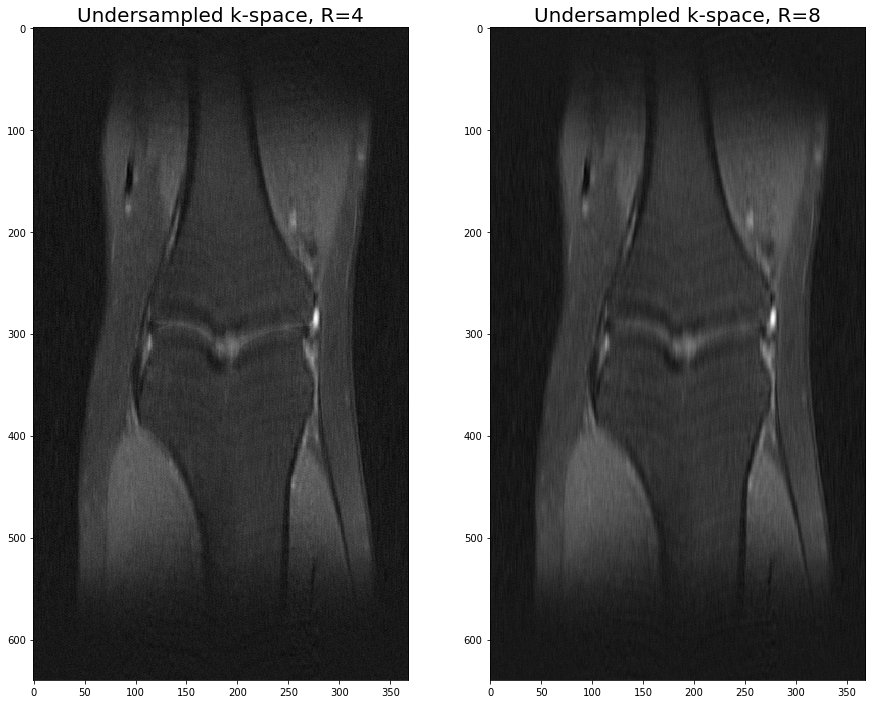

In [9]:
plt.figure(figsize=(15, 12))
zero_filled_images = {}
for i, (acc, undersampled_kspace) in enumerate(undersampled_kspaces.items()):
    undersampled_slice_image = single_coil_kspace_to_image(undersampled_kspace)
    zero_filled_images[acc] = undersampled_slice_image
    
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(undersampled_slice_image[0], cmap='gray')
    plt.title(f'Undersampled k-space, R={acc}', fontsize=20)
    
plt.show()

In the previous experiment, we used a considerable fraction of the center of k-space data. Let us look at what happens if we try to shift the balance towards low frequencies to preserve more details.

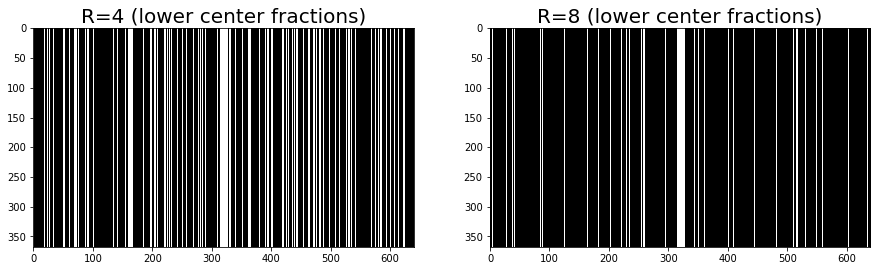

In [10]:
center_fractions = [0.02]
accelerations = [4, 8]
masks_lower_center = {}

plt.figure(figsize=(15, 7))
for i, acc in enumerate(accelerations):
    mask_generator = RandomMaskFunc(center_fractions, [acc])
    mask = mask_generator(kspace.shape)
    masks_lower_center[acc] = mask
    ones = torch.ones(kspace.shape)
    mask_2d = ones * mask
    
    plt.subplot(1, len(accelerations), i + 1)
    plt.imshow(mask_2d[0].T, cmap='gray')
    plt.title(f'R={acc} (lower center fractions)', fontsize=20)
    
plt.show()

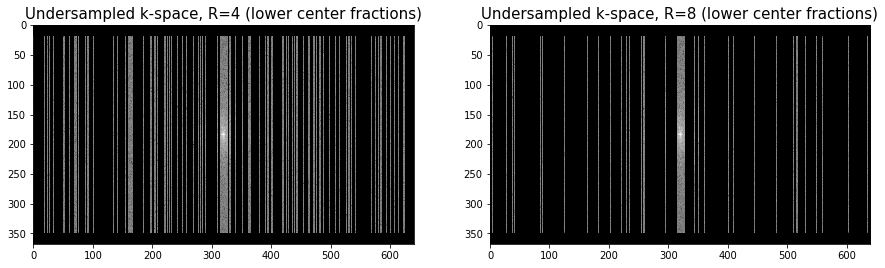

In [58]:
slice_num = 20
slice_kspace = kspace[slice_num]
undersampled_kspaces_lower_center = {}

plt.figure(figsize=(15, 7))
for i, (acc, mask) in enumerate(masks_lower_center.items()):
    undersampled_kspace = slice_kspace * mask
    undersampled_kspaces_lower_center[acc] = undersampled_kspace

    magnitude_slice_kspace = complex_abs(to_two_channel_complex(undersampled_kspace))
    magnitude_slice_kspace_to_show = torch.log(magnitude_slice_kspace + 1e-8)
    
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(magnitude_slice_kspace_to_show[0].T, cmap='gray')
    plt.title(f'Undersampled k-space, R={acc} (lower center fractions)', fontsize=15)
    
plt.show()

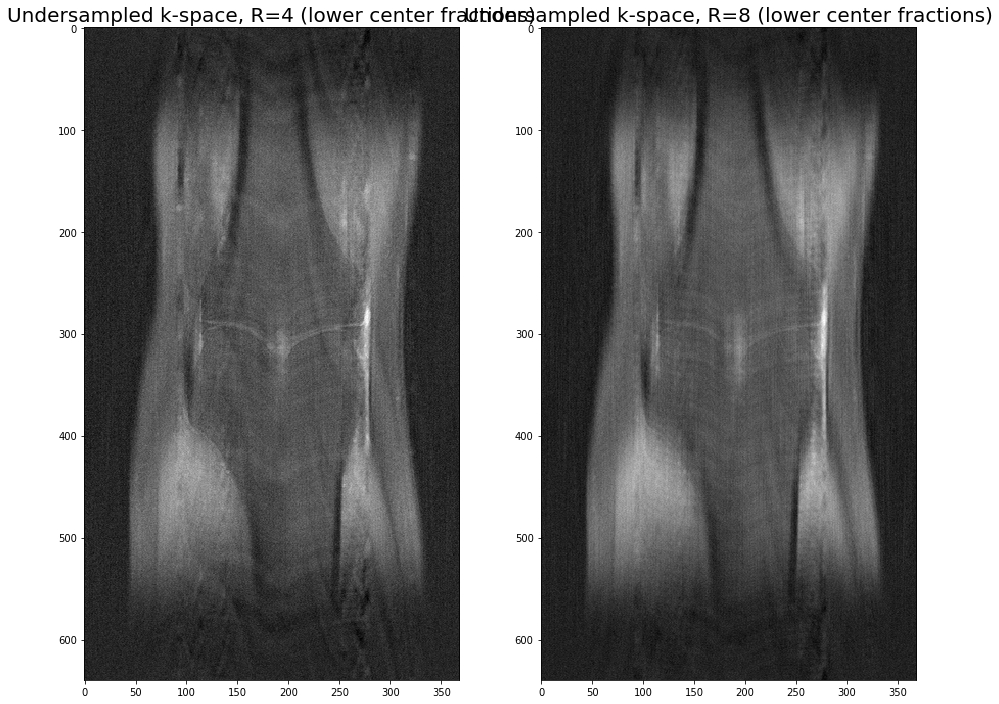

In [12]:
plt.figure(figsize=(15, 12))
for i, (acc, undersampled_kspace) in enumerate(undersampled_kspaces_lower_center.items()):
    undersampled_slice_image = single_coil_kspace_to_image(undersampled_kspace)
    
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(undersampled_slice_image[0], cmap='gray')
    plt.title(f'Undersampled k-space, R={acc} (lower center fractions)', fontsize=20)
    
plt.show()

As you can see, in this case, general structural information degraded more significantly. Even though previous pictures may be more visually pleasing, it is not clear which sampling strategy is more beneficial prior to reconstruction.

## Part 3. A baseline solution

This part will consider the baseline solution of our reconstruction problem provided by organizers of the fastMRI challenge. [U-Net architecture](https://arxiv.org/abs/1505.04597) is a widely used neural network architecture for image-to-image tasks, which gained its popularity several years ago, especially in the medical domain. Even though this architecture is not new and has multiple more modern alternatives, it remains a powerful tool, often considered a baseline model.

In [13]:
def download_model(url, fname):
    response = requests.get(url, timeout=10, stream=True)

    chunk_size = 1 * 1024 * 1024  # 1 MB chunks
    total_size_in_bytes = int(response.headers.get("content-length", 0))
    progress_bar = tqdm(
        desc="Downloading state_dict",
        total=total_size_in_bytes,
        unit="iB",
        unit_scale=True,
    )

    with open(fname, "wb") as fh:
        for chunk in response.iter_content(chunk_size):
            progress_bar.update(len(chunk))
            fh.write(chunk)

    progress_bar.close()

In this demo, we do not train a U-Net model from scratch but instead use a pre-trained one provided by organizers of the fastMRI challenge. Find reference code in the [official repository of the challenge](https://github.com/facebookresearch/fastMRI). You can train your model using code sampled provided by challenge organizers.

In [14]:
UNET_FOLDER = "https://dl.fbaipublicfiles.com/fastMRI/trained_models/unet/"
MODEL_FNAMES = {
    "unet_knee_sc": "knee_sc_leaderboard_state_dict.pt",
    "unet_knee_mc": "knee_mc_leaderboard_state_dict.pt",
    "unet_brain_mc": "brain_leaderboard_state_dict.pt",
}
challenge = "unet_knee_sc"

# Initialize U-Net architecture. See `models.py` for mode details
model = Unet(in_chans=1, out_chans=1, chans=256, num_pool_layers=4, drop_prob=0.0)

# Download pretraned model weights
if not Path(MODEL_FNAMES[challenge]).exists():
    url_root = UNET_FOLDER
    download_model(url_root + MODEL_FNAMES[challenge], MODEL_FNAMES[challenge])

# Override standard initialization with pretrained weights
state_dict_file = MODEL_FNAMES[challenge]
model.load_state_dict(torch.load(state_dict_file))

# Move the model into the evaluation mode: in the mode the model will not train on provided data. 
# Use it only during inference.
model = model.eval()

Previously, we prepared and visualized raw and image data ourselves. However, the authors of the pre-trained model used slightly different preprocessing during training of the U-Net model. The significant difference is normalization and the way the undersampling mask is applied. Since data preparation is crucial for any model to work correctly, we will use their preprocessing to reproduce results accurately. Check out `data_transforms.py` for more details.

In [30]:
offset = 24
data_collection = {}
center_fractions = [0.08]
for acc in accelerations:
    mask_func = RandomMaskFunc(center_fractions, [acc])
    data_transform = UnetDataTransform(which_challenge="singlecoil", mask_func=mask_func)
    image, _, mean, std, _, _, _, mask = data_transform(kspace=kspace,
                                                  target=target,
                                                  mask=None,
                                                  attrs=attrs,
                                                  fname=file_name,
                                                  slice_num=slice_num)
    data_collection[acc] = (image, mean, std, mask)

Having preprocessed data at hand, we perform reconstruction and visualize our results.

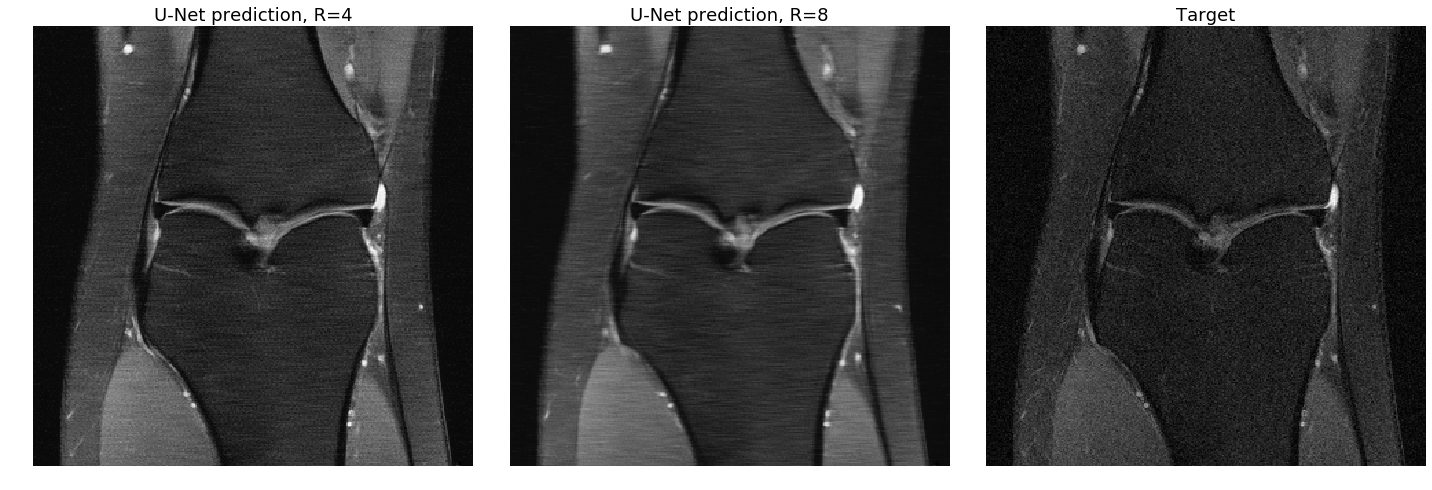

In [53]:
plt.figure(figsize=(20, 14))
recons = {}
for i, (acc, data) in enumerate(data_collection.items()):
    zero_filled_image, mean, std, mask = data  # shape [1, height, width]
    zero_filled_image = zero_filled_image.unsqueeze(0)  # shape [1, 1, height, width]
    
    # Perform reconstruction
    output = model(zero_filled_image[:, slice_num, ...].unsqueeze(1)).squeeze(1)
    
    # De-normalize data the way it is done in the original implementation
    output = (output * std + mean).detach().cpu().numpy()
        
    # Squeeze dimentions to represent an image as grayscale 2D tensor (for visualization)
    output = np.squeeze(output)
    recons[acc] = output
    
    # Save results for later
    if acc == 4:
        os.makedirs('out', exist_ok=True)
        np.save('out/kspace.npy', kspace)
        np.save('out/zero_filled_4.npy', zero_filled_image[:, slice_num, ...])
        np.save('out/recon_4.npy', output)
        np.save('out/mask.npy', mask[0, 0, offset: mask.shape[2] - offset, 0])
    
    # Visualize residual
    plt.subplot(1, len(zero_filled_images) + 1, i + 1)
    plt.imshow(output, cmap='gray')
    plt.title(f'U-Net prediction, R={acc}', fontsize=18)
    plt.axis('off')
    
plt.subplot(1, len(zero_filled_images) + 1, len(zero_filled_images) + 1)
plt.imshow(target[slice_num], cmap='gray')
plt.title(f'Target', fontsize=18)
np.save('out/target.npy', target[slice_num])

plt.axis('off')
plt.tight_layout()
plt.show()

Let us now estimate the quality of obtained reconstruction using a commonly used metric for image quality assessment called Structural Similarity Index (SSIM), where higher - better.

In [57]:
for acc in accelerations:
    
    # Normalize data before SSIM computation because it is very sensitive for data range
    recon_normalized = normalize_tensor(torch.from_numpy(recons[acc]))
    target_normalized = normalize_tensor(torch.from_numpy(target[slice_num]))

    ssim_value = ssim(recon_normalized, target_normalized, data_range=1.)
    print(f'Resulting SSIM score for R={acc}:', round(ssim_value.item(), 4))

Resulting SSIM score for R=4: 0.6132
Resulting SSIM score for R=8: 0.5306
